In [1]:
# This notebook contasins the code to differentiate images based on sports

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
from os import listdir
import wget

## Loading the data

In [4]:
PATH = "/home/ubuntu/datasets/sports_images/"
sz=224

In [5]:
files = listdir(f'{PATH}baseball')[:5]
files

['bs5.jpg', 'bs21.jpg', 'bs29.jpg', 'bs25.jpg', 'bs10.jpg']

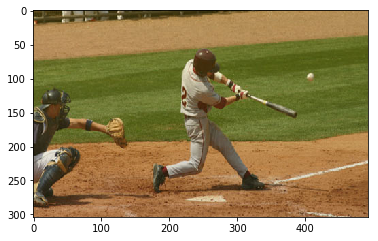

In [6]:
img = plt.imread(f'{PATH}baseball/{files[0]}')
plt.imshow(img);

The numbers above mean the image has 304*493 pixels with 3 channels (R, G, and B)

In [7]:
img.shape

(304, 493, 3)

Lets verify it using img.size function

In [8]:
img.size

449616

In [9]:
304*493*3

449616

Let's have a look at what type of numbers are stored by selecting first 4 rows and columns.

In [16]:
img[:4,:4]

array([[[ 84,  66,  20],
        [ 84,  66,  20],
        [ 91,  73,  27],
        [ 86,  68,  22]],

       [[ 95,  77,  31],
        [ 95,  77,  31],
        [100,  82,  36],
        [ 94,  76,  30]],

       [[ 97,  80,  36],
        [ 95,  78,  34],
        [ 99,  82,  38],
        [ 92,  75,  31]],

       [[ 81,  66,  23],
        [ 80,  65,  22],
        [ 83,  68,  25],
        [ 76,  61,  18]]], dtype=uint8)

## Building a simple model

We're going to use a pre-trained model, that is, a model created by someone else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

### Download pre-trained models

I used the following links to download the model

    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'

In [10]:
url = "https://download.pytorch.org/models/resnet152-b121ed2d.pth"
wget.download(url, '/home/ubuntu/pretrained_models/')

'/home/ubuntu/pretrained_models//resnet152-b121ed2d.pth'

Lets check the size of each model

In [12]:
!ls -l --block-size=M /home/ubuntu/pretrained_models/

total 499M
-rw-rw-r-- 1 ubuntu ubuntu 171M Jan  9 19:12 resnet101-5d3b4d8f.pth
-rw-r--r-- 1 ubuntu ubuntu 231M Jan  9 19:17 resnet152-b121ed2d.pth
-rw-rw-r-- 1 ubuntu ubuntu  98M Jan  9 19:11 resnet50-19c8e357.pth


As you can see above, when the number of number of layers double the pre-trained models also double in size.

Another simple way is to just import it from torchvision

In [13]:
from torchvision.models import resnet18
from torchvision.models import resnet34

In [17]:
# We are using pre-trained model called resnet34
arch=resnet34
# and then use arch as parameter

If you wish to check all available pretrained models:

In [18]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'Inception3',
 'ResNet',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

### Data Preprocessing

In [23]:
from torchvision import transforms
transform = transforms.Compose([            
 transforms.Resize(256),                    # Resize the image to 256×256 pixels.
 transforms.CenterCrop(224),                # Crop the image to 224×224 pixels about the center.
 transforms.RandomHorizontalFlip(),          # As these are sports images lets do only horrizonal flip
 transforms.ToTensor(),                     # Convert the image to PyTorch Tensor data type.
 transforms.Normalize(                      # Normalize the image by setting its mean and standard deviation to the specified values.
 mean=[0.485, 0.456, 0.406],            
 std=[0.229, 0.224, 0.225]                  
 )])

List of all transforms here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [24]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
102502400it [00:08, 12691044.85it/s]


In [25]:
 def from_paths(cls, path, bs=64, tfms=(None,None), trn_name='train', val_name='valid', test_name=None, test_with_labels=False, num_workers=8):
        """ Read in images and their labels given as sub-folder names
        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            trn_name: a name of the folder that contains training images.
            val_name:  a name of the folder that contains validation images.
            test_name:  a name of the folder that contains test images.
            num_workers: number of workers
        Returns:
            ImageClassifierData
        """
        assert not(tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        trn,val = [folder_source(path, o) for o in (trn_name, val_name)]
        if test_name:
            test = folder_source(path, test_name) if test_with_labels else read_dir(path, test_name)
        else: test = None
        datasets = cls.get_ds(FilesIndexArrayDataset, trn, val, tfms, path=path, test=test)
        return cls(path, datasets, bs, num_workers, classes=trn[2])

In [30]:
from .layer_optimizer import *

ModuleNotFoundError: No module named '__main__.layer_optimizer'; '__main__' is not a package

In [29]:
def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=None,
                    tfm_y=None, sz_y=None, pad_mode=BORDER_REFLECT, norm_y=True, scale=None):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)
    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms, max_zoom=max_zoom, pad=pad, crop_type=crop_type,
                           tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode, norm_y=norm_y, scale=scale)

NameError: name 'BORDER_REFLECT' is not defined

In [26]:
## Following 3 lines of code is used to train the model

## ImageClassifierData.from_paths
# Read in images and their labels given as sub-folder names
# tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
data = from_paths(PATH, tfms=transform(resnet, sz))


TypeError: __call__() takes 2 positional arguments but 3 were given

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
# We are working with two types of objects, data - contains training/validation set, learn - contains the model

In [ ]:
## learn.fit()
# The first parameter in learn.fit specifies the learning rate
# The second parameter in learn.fit specifies the number of epochs
learn.fit(0.01, 4)